In [50]:
import numpy.typing as npt
import skimage.data
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from skimage import img_as_float


def get_data():
    data = skimage.data.cells3d()
    z = data.shape[0] // 2
    return img_as_float(data[z, ...])


initial = get_data()


def plot_two_images(im0: npt.NDArray, im1: npt.NDArray, *, title: str):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig: Figure
    ax0: Axes = axes[0]
    ax0.imshow(im0)
    ax0.axis('off')

    ax1: Axes = axes[1]
    ax1.imshow(im1)
    ax1.axis('off')

    fig.suptitle(title)
    fig.tight_layout()

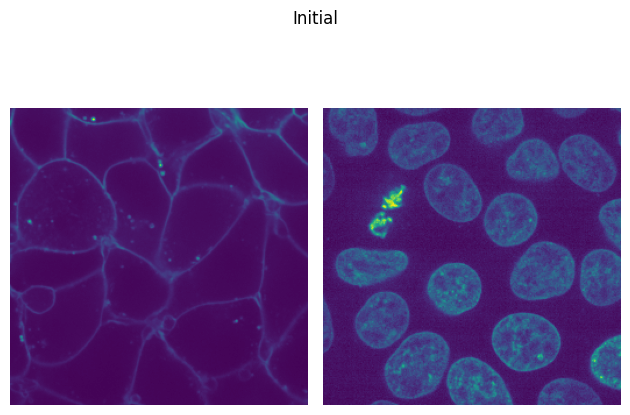

In [51]:
plot_two_images(initial[0], initial[1], title='Initial')

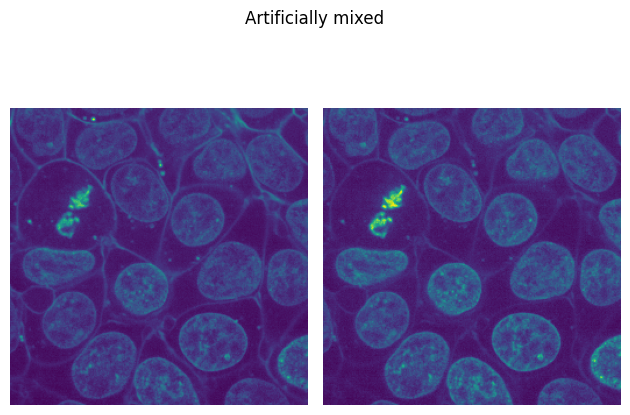

In [53]:
import numpy as np

# make up a mixing matrix
mixing_matrix = np.array([[1.0, 0.6], [0.7, 1.0]])
mixed = np.einsum("ij,jkl->ikl", mixing_matrix, initial)

plot_two_images(mixed[0], mixed[1], title='Artificially mixed')

In [117]:
from picasso.unmixing import compute_unmixing_matrix
from skimage.transform import downscale_local_mean

mixed_downscaled = downscale_local_mean(mixed, (1, 2, 2))
mat_iters = compute_unmixing_matrix(
    mixed_downscaled, verbose=True, return_iters=True, constrain_diag=True,
)
unmixing_matrix = mat_iters[-1]
print(unmixing_matrix)

unmixing iters: 75it [00:00, 95.02it/s]

[[ 1.         -0.57219621]
 [-0.7067118   1.        ]]


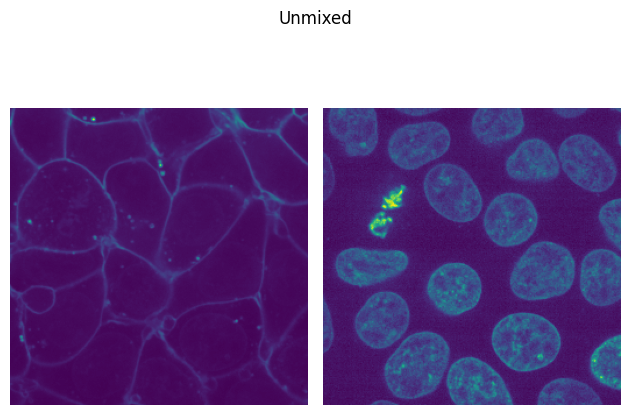

In [118]:
unmixed = np.einsum('ij,jkl->ikl', unmixing_matrix, mixed)
np.clip(unmixed, 0, 1, out=unmixed)

plot_two_images(unmixed[0], unmixed[1], title='Unmixed')

In [124]:
import pygifsicle
from skimage.exposure import rescale_intensity
from pathlib import Path
from skimage import img_as_ubyte
import sys
import imageio
from tqdm import tqdm


def make_gif(dst: Path, mat_iters: npt.NDArray, image: npt.NDArray, *, n=60):
    if len(mat_iters) > n:
        inds = np.linspace(0, len(mat_iters) - 1, n, dtype=int)
    else:
        inds = np.arange(len(mat_iters))

    frames = []
    for ind in tqdm(inds, file=sys.stdout, desc='Making unmixing iters'):
        frame = np.einsum('ij,jkl->ikl', mat_iters[ind], image)
        frames.append(frame)

    frames = np.stack(frames)
    frames = np.concatenate([frames[:, 0, ...], frames[:, 1, ...]], axis=2)
    max_val = np.percentile(frames[-1], 99.5)
    frames = rescale_intensity(frames, in_range=(0, max_val))
    frames = img_as_ubyte(frames)

    dst.parent.mkdir(exist_ok=True, parents=True)
    imageio.mimwrite(dst, frames, duration=0.1)
    pygifsicle.optimize(dst)


dst = Path('./assets/unmixing-iters.gif')
make_gif(dst, mat_iters, mixed)

Making unmixing iters: 100%|██████████| 60/60 [00:00<00:00, 2190.47it/s]


gifsicle: warning: trivial adaptive palette (only 248 colors in source)



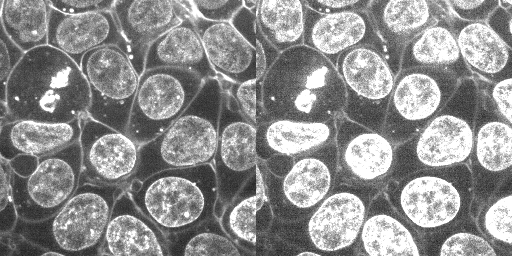

In [125]:
from IPython.core.display import HTML
import base64

with open(dst, 'rb') as fd:
    b64 = base64.b64encode(fd.read()).decode('ascii')
    display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

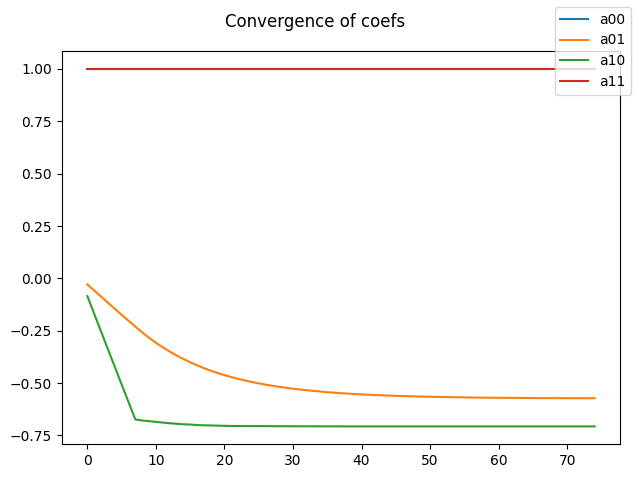

In [119]:
fig, ax = plt.subplots()
fig: Figure
ax: Axes
x = range(len(mat_iters))
ax.plot(mat_iters[:, 0, 0], label='a00')
ax.plot(mat_iters[:, 0, 1], label='a01')
ax.plot(mat_iters[:, 1, 0], label='a10')
ax.plot(mat_iters[:, 1, 1], label='a11')
fig.legend()
fig.suptitle("Convergence of coefs")
fig.tight_layout()